In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 77.6 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 70.3 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 43.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 74.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3830, done.
remote: Counting objects: 100% (473/473), done.
remote: Compressing objects: 100% (261/261), done.
remote: Total 3830 (delta 248), reused 402 (delta 205), pack-reused 3357
Receiving objects: 100% (3830/3830), 649.88 MiB | 34.44 MiB/s, done.
Resolving deltas: 100% (2204/2204), done.
Updating files: 100% (248/248), done.


In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Create datasets & dataloader

In [6]:
from torchvision import transforms
from going_modular.going_modular import data_setup

IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [7]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

## 3 Replicating ViT: Overview

```python


x_input = [class_token, image_patch_1, image_patch_2, ..., image_patch_N] + [class_token_pos, image_patch_1_pos, ..., image_patch_N_pos]
### Input Layer
### Inside transformer Encoder:
def MHABlock(x):
    x = LayerNorm(x_input)
    x = MHA(x)
    x = x_input + x
    return x

def MLPBlock(x_input):
    x = LayerNorm(x_input)
    x = MLP(x)
    x = x + x_input
    return x

def EncoderBlock(x_input):
    x = MHABlock(x)
    x = MLPBlock(x)
    return x


```

 ### Working with shapes

 Eq1: Split the data into patches and creating class, pos and patch embeddings

 * Input shape: (224, 224, 3)
 * Output shape: $N \times (P^2 * C)$

In [8]:
# Create example values
width, height = (224, 224)
color_channels = 3
patch_size = 16

# Calculate the number of patches

number_of_patches = int((height * width)/patch_size**2)
number_of_patches

196

In [9]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

In [10]:
embedding_layer_input_shape, embedding_layer_output_shape

((224, 224, 3), (196, 768))

### Turning a singe image into patches

In [11]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]



In [12]:
train_dataloader.dataset.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

Text(0.5, 1.0, 'tensor(2)')

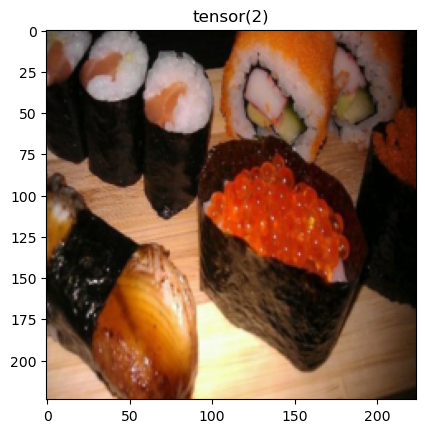

In [13]:
plt.imshow(image.permute(1, 2, 0))
plt.title(label)

In [14]:
image.shape

torch.Size([3, 224, 224])

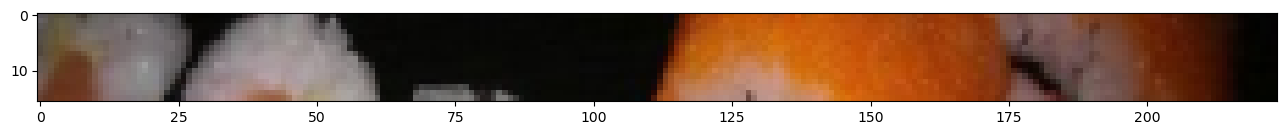

In [15]:
image_permuted = image.permute(1, 2, 0)

plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

### Creating image patches and turning them into patch embeddings

In [16]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddigns)
import torch
from torch import nn
patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=16,
                   stride=16,
                   padding=0)

In [17]:
out = conv2d(image.unsqueeze(0))
print(out.shape)

torch.Size([1, 768, 14, 14])


In [18]:
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3) #flatten 2 to 3 dims

### Flattening conv2d feature map

In [19]:
out = flatten_layer(out)
out.shape

torch.Size([1, 768, 196])

In [20]:
out = out.permute(0, 2, 1)
out.shape

torch.Size([1, 196, 768])

In [21]:
# Create example values
width, height = (224, 224)
color_channels = 3
patch_size = 16

# Calculate the number of patches

number_of_patches = int((height * width)/patch_size**2)
number_of_patches

196

In [22]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels: int=3,
                 patch_size: int=16,
                 embedding_dim: int=768):
        super().__init__()
        self.patch_size = patch_size
        self.patcher = nn.Conv2d(in_channels,
                                 embedding_dim,
                                 patch_size,
                                 patch_size,
                                 0)
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)

    def forward(self,
                x: torch.Tensor) -> torch.Tensor:
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image must be divisable by patch_size, image_res: {image_resolution}, patch_size: {self.patch_size}"
        return self.flatten(self.patcher(x)).permute(0, 2, 1)

In [23]:
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768,)
test_sample = image.unsqueeze(0)
patched_test_sample = patchify(test_sample)
patched_test_sample.shape

torch.Size([1, 196, 768])

In [24]:
bad_image = torch.randn(1, 3, 250, 250)
#patchify(bad_image)

### Creating the class token embedding

In [25]:


embedding_dim = 768
batch_size = 1
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dim))
class_token.shape

torch.Size([1, 1, 768])

In [26]:
# Concatenating the class token embedding to the front of the patch embedding
patched_test_sample_with_class_emb = torch.cat([class_token, patched_test_sample], dim=1)
patched_test_sample_with_class_emb.shape

torch.Size([1, 197, 768])

### Doing pos embedding

In [27]:
number_of_patches = int((height * width)/patch_size**2)
embedding_dim = 768

In [28]:
number_of_patches

196

In [29]:
position_embedding = nn.Parameter(torch.ones(batch_size,
                                             number_of_patches + 1,
                                             embedding_dim))
position_embedding.shape

torch.Size([1, 197, 768])

In [30]:
class ClsTokenPosEmbedder(nn.Module):
    def __init__(self,
                 in_channels: int=3,
                 patch_size: int=16,
                 embedding_dim: int=768):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.class_token = nn.Parameter(torch.randn(1, 1, self.embedding_dim))
        self.position_embedding = nn.Parameter(torch.ones(1,
                                                          number_of_patches + 1,
                                                          self.embedding_dim))

    def forward(self,
                x: torch.Tensor) -> torch.Tensor:

        assert x.shape[-1] == self.embedding_dim, f"input dim must be {self.embedding_dim}"
        input_shape = list(x.shape)
        input_shape[1] = -1 #do not expand on the
        x = torch.cat([self.class_token.expand(input_shape), x],
                       dim=1)
        x = x + self.position_embedding
        return x

### MSA Block

In [31]:
class MultiHeadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int=768,    # Hidden dim from the paper
                 num_heads: int=12,         # Heads from Table 1
                 attn_dropout: float=0.0,
                 ):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)


    def forward(self,
                x: torch.Tensor):
        x = self.layer_norm(x) # input_dim = (b_size, seq_len, hidden_dim)
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output


In [32]:
multihead_self_attention_block = MultiHeadSelfAttentionBlock()

In [33]:
class MLPBlock(nn.Module):
    def __init__(self,
                 hidden_dim: int=768,
                 mlp_size: int=3072,
                 dropout: float=0.1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.mlp_size = mlp_size

        self.layer_norm = nn.LayerNorm(normalized_shape=self.hidden_dim)
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_dim, self.mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),

            nn.Linear(self.mlp_size, self.hidden_dim),
            nn.Dropout(p=dropout)
            )

    def forward(self, x: torch.Tensor):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x


In [34]:
mlpblock = MLPBlock()

In [35]:
patched_test_sample_with_class_emb.shape

torch.Size([1, 197, 768])

In [36]:
mlpblock(patched_test_sample_with_class_emb).shape

torch.Size([1, 197, 768])

### Creating the transformer encoder


In [37]:
class Encoder(nn.Module):
    def __init__(self,
                 embedding_dim: int=768,
                 num_heads: int=12,
                 mlp_size: int=3072,
                 mlp_dropout: float=0.1,
                 attn_dropout: float=0.0):
        super().__init__()

        self.mha = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                               num_heads=num_heads,
                                               attn_dropout=attn_dropout)

        self.mlp = MLPBlock(hidden_dim=embedding_dim,
                            mlp_size=mlp_size,
                            dropout=mlp_dropout)

    def forward(self, x: torch.Tensor):
        x = self.mha(x) + x
        x = self.mlp(x) + x
        return x


In [38]:
encoderblock = Encoder()

In [39]:
patched_test_sample_with_class_emb.shape

torch.Size([1, 197, 768])

In [40]:
encoderblock(patched_test_sample_with_class_emb)

tensor([[[-0.4687,  0.4009,  0.5122,  ...,  0.6964,  0.5156, -0.4613],
         [ 0.4525, -0.2695, -0.0339,  ...,  0.0362, -0.2879, -1.0389],
         [ 0.3451, -0.0339,  0.2763,  ...,  0.2541,  0.1246, -1.1679],
         ...,
         [ 0.5922, -0.3518, -0.1105,  ...,  0.3121, -0.1863, -1.3183],
         [ 0.2766, -0.2416,  0.0985,  ...,  0.2540, -0.0809, -1.1165],
         [ 0.1154, -0.0710,  0.1902,  ...,  0.4895, -0.0903, -0.9469]]],
       grad_fn=<AddBackward0>)

In [41]:
summary(model=encoderblock,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
Encoder (Encoder)                                  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (mha)                [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp)                                   [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### ViT assembly

In [42]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels: int=3,
                 patch_size: int=16,
                 embedding_dim: int=768):
        super().__init__()
        self.patch_size = patch_size
        self.patcher = nn.Conv2d(in_channels,
                                 embedding_dim,
                                 patch_size,
                                 patch_size,
                                 0)
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)

    def forward(self,
                x: torch.Tensor) -> torch.Tensor:
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image must be divisable by patch_size, image_res: {image_resolution}, patch_size: {self.patch_size}"
        return self.flatten(self.patcher(x)).permute(0, 2, 1)

class ClsTokenPosEmbedder(nn.Module):
    def __init__(self,
                 in_channels: int=3,
                 patch_size: int=16,
                 embedding_dim: int=768,
                 number_of_patches: int=196):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.class_token = nn.Parameter(torch.randn(1, 1, self.embedding_dim))
        self.position_embedding = nn.Parameter(torch.ones(1,
                                                          number_of_patches + 1,
                                                          self.embedding_dim))

    def forward(self,
                x: torch.Tensor) -> torch.Tensor:

        assert x.shape[-1] == self.embedding_dim, f"input dim must be {self.embedding_dim}"
        input_shape = list(x.shape)
        input_shape[1] = -1 #do not expand on the
        x = torch.cat([self.class_token.expand(input_shape), x],
                       dim=1)
        x = x + self.position_embedding
        return x


class Encoder(nn.Module):
    def __init__(self,
                 embedding_dim: int=768,
                 num_heads: int=12,
                 mlp_size: int=3072,
                 mlp_dropout: float=0.1,
                 attn_dropout: float=0.0):
        super().__init__()

        self.mha = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                               num_heads=num_heads,
                                               attn_dropout=attn_dropout)

        self.mlp = MLPBlock(hidden_dim=embedding_dim,
                            mlp_size=mlp_size,
                            dropout=mlp_dropout)

    def forward(self, x: torch.Tensor):
        x = self.mha(x) + x
        x = self.mlp(x) + x
        return x


In [43]:
class ViT(nn.Module):
    def __init__(self,
                 img_size: int=224,
                 in_channels: int=3,
                 patch_size: int=16,
                 num_transformer_layers: int=12,
                 embedding_dim: int=768,
                 mlp_size: int=3072,
                 num_heads: int=12,
                 attn_dropout: float=0.0,
                 mlp_dropout: float=0.1,
                 embedding_dropout: int=0.1, # for patch & pos embeddings
                 num_classes: int=1000):
        super().__init__()

        assert img_size % patch_size == 0,  "Image size must be dividable by patch_size"

        self.num_patches = img_size**2//patch_size**2



        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                            patch_size=patch_size,
                                            embedding_dim=embedding_dim)
        self.pos_cls_embedding = ClsTokenPosEmbedder(in_channels=in_channels,
                                                    patch_size=patch_size,
                                                    embedding_dim=embedding_dim,
                                                    number_of_patches=self.num_patches)
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        self.transformer_encoder = nn.Sequential(*[Encoder(embedding_dim=embedding_dim,
                                                           num_heads=num_heads,
                                                           mlp_size=mlp_size,
                                                           mlp_dropout=mlp_dropout,
                                                           attn_dropout=attn_dropout) for _ in range(num_transformer_layers)])

        self.classification_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=num_classes)
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.patch_embedding(x)
        x = self.pos_cls_embedding(x)
        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        x = self.classification_head(x[:, 0, :])
        return x


In [44]:
vit = ViT(num_classes=3)


In [45]:
summary(model = vit,
        input_size = (32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              --                   True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─ClsTokenPosEmbedder (pos_cls_embedding)                    [32, 196, 768]       [32, 197, 768]       152,064              True
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]

### Traning starts

In [46]:
base_lr = 1e-3
weight_decay = 0.1
grad_clipping = 1.0
warmup_steps = 10000

optimizer = torch.optim.Adam(vit.parameters(),
                             lr=base_lr,
                             weight_decay=weight_decay,
                             )
loss_fn = torch.nn.CrossEntropyLoss()



In [47]:
from going_modular.going_modular import engine

set_seeds()
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       epochs=10,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.8185 | train_acc: 0.3789 | test_loss: 2.2982 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.7492 | train_acc: 0.2539 | test_loss: 1.3752 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.9845 | train_acc: 0.3008 | test_loss: 1.2883 | test_acc: 0.5417
Epoch: 4 | train_loss: 1.2303 | train_acc: 0.4375 | test_loss: 1.9014 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.3495 | train_acc: 0.4375 | test_loss: 1.6415 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1339 | train_acc: 0.4102 | test_loss: 2.4694 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.5931 | train_acc: 0.3281 | test_loss: 2.4237 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.6966 | train_acc: 0.2812 | test_loss: 1.6147 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.4429 | train_acc: 0.3984 | test_loss: 1.5213 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.5922 | train_acc: 0.2969 | test_loss: 1.6113 | test_acc: 0.2604


### Using pretrained vit

In [48]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

In [51]:
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 152MB/s]  


In [52]:
pretrained_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [54]:
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

pretrained_vit.heads = nn.Linear(in_features=768,
                                 out_features=3)

In [ ]:
summary(model=encoderblock,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

In [57]:
summary(pretrained_vit,
        input_size=(32, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names']
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [ ]:
summary(model=encoderblock,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

In [60]:
base_lr = 1e-3
weight_decay = 0.1
grad_clipping = 1.0
warmup_steps = 10000

optimizer = torch.optim.Adam(pretrained_vit.parameters(),
                             lr=base_lr,
                             weight_decay=weight_decay,
                             )
loss_fn = torch.nn.CrossEntropyLoss()



In [61]:
from going_modular.going_modular import engine

set_seeds()
results = engine.train(model=pretrained_vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       epochs=10,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8071 | train_acc: 0.6445 | test_loss: 0.6462 | test_acc: 0.7557
Epoch: 2 | train_loss: 0.4539 | train_acc: 0.9102 | test_loss: 0.4182 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.2964 | train_acc: 0.9414 | test_loss: 0.3292 | test_acc: 0.8977
Epoch: 4 | train_loss: 0.2315 | train_acc: 0.9492 | test_loss: 0.2804 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.1881 | train_acc: 0.9609 | test_loss: 0.2638 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1755 | train_acc: 0.9648 | test_loss: 0.2415 | test_acc: 0.9176
Epoch: 7 | train_loss: 0.1667 | train_acc: 0.9648 | test_loss: 0.2460 | test_acc: 0.8977
Epoch: 8 | train_loss: 0.1403 | train_acc: 0.9688 | test_loss: 0.2479 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.1784 | train_acc: 0.9766 | test_loss: 0.2128 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.1359 | train_acc: 0.9609 | test_loss: 0.1978 | test_acc: 0.9479


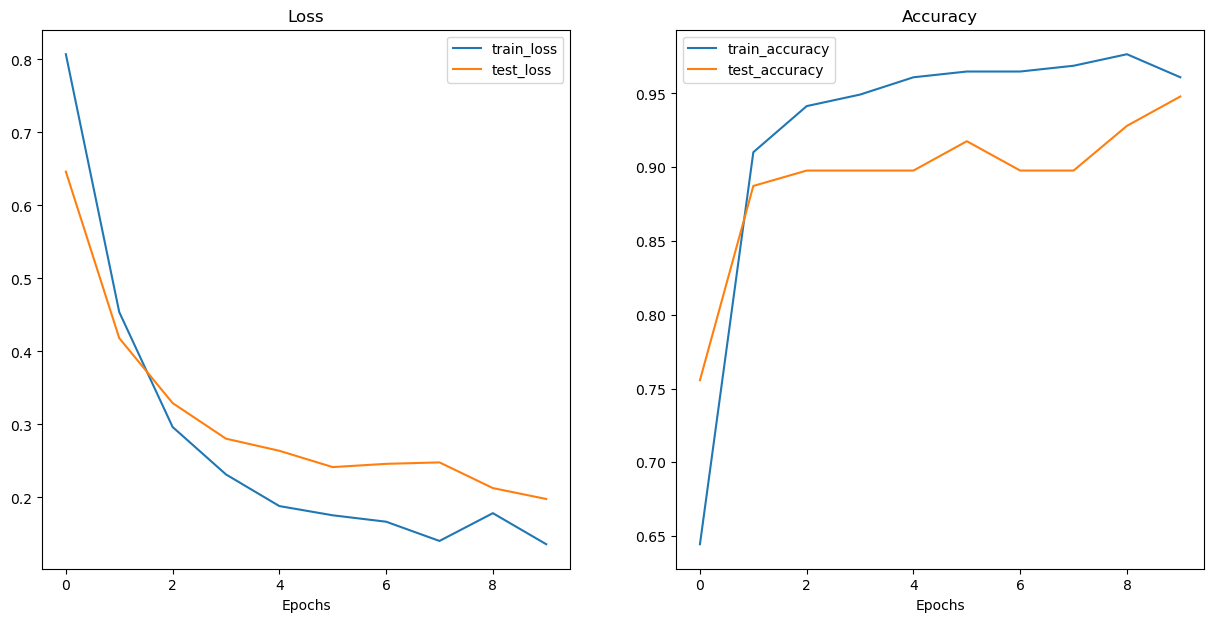

In [62]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)